Evaluate a model

In [2]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import agent as rl
from datetime import datetime
import utils
import os

In [3]:
def show_model_activations(model):
    
    # just one neuron is enough.
    for i in range(1):
        plt.imshow(model["W1"][i,:].reshape((80,80)))
        plt.colorbar()
        plt.show()    
    plt.plot(model['W2'])
    plt.show()

    
def format_score(score):
    return "{0:.1f} ± {1:.1f} [95% CI]".format(score[1], 1.96 * score[2])


def smooth(data, lam = 0.90):
    if len(data) == 0:
        return []
    y = data[0]
    result = []
    for x in data:
        y = lam * y + (1-lam) * x
        result.append(y)
    return result

def plot_scores(score_history):
    x = [k for k in score_history.keys()]
    y = [score_history[k][0] for k in score_history.keys()]
    
    plt.plot(x,y)
    plt.show()

    
def count_params(model):
    total = 0
    for k in model.keys():
        total += np.prod(model[k].shape)
    return total

def plot_ema(ema_history):
    x = [a for (a,b) in ema_history]
    y = [b for (a,b) in ema_history]
    plt.plot(x,smooth(y))
    plt.show()
    
    
def show_stats(name):
    
    stat_display_format = {                      
        'last_episode_time': "{0}",
        'last_episode_frames': "{0}",
        'last_episode_frame_time': "{0:.2f}ms",
        'last_episode_score': "{0:.2f}",
        'last_episode_prepro_time': "{0:.0f}ms",
        'last_episode_forward_time': "{0:.0f}ms",
        'last_episode_step_time': "{0:.0f}ms",
        'last_batch_score_mean': "{0:.1f}",
        'last_batch_score_std': "{0:.2f}",
        'last_batch_time': "{0}",
        'total_training_time': "{0:.1f} hours"
    }

    save_package = pickle.load(open('models/'+name+".p", 'rb'))
    params = save_package['params']
    episode = save_package['episodes']
    rmsprop_cache = save_package['rmsprop']
    score_history = save_package['history'] if 'history' in save_package else {}
    stats = save_package['stats'] 
    config = save_package['config'] 
        
    print("Model '{0}' with {1} episodes.".format(name, episode))    
    print("Format is [{0}] with {1:.1f}m parameters.".format(params['W1'].dtype, count_params(params)/1e6))
    print()
    print("stats:")
    for k,v in stats.items():
        if k in stat_display_format:
            if k == 'total_training_time':
                v = v / (60.0*60.0) # make total training time in hours
            print("    "+k+":", stat_display_format[k].format(v))
    print()
    
    config.display()
    
    print()
    
    if len(score_history) > 0:
        keys = list(score_history.keys())
        keys.sort()
        scores = [(k, score_history[k][0], score_history[k][1]) for k in keys]        
        print("Last score:" + format_score(scores[-1]))
    else:
        print("No score history yet.")                    
        
    plot_scores(score_history)
    show_model_activations(params)
    if 'ema_history' in stats:
        plot_ema(stats['ema_history'])
        
    if 'last_batch_rewards' in stats:
        print(stats['last_batch_rewards'])
        
        
def compare_models(model_names, lam = 0.95, bounds = (100,10000), both = True):
    """ Compare peformance of models over time. """
    
    plots = 2 if both else 1
    
    # ema
    plt.subplot(1, plots, 1)
    for name in model_names:
        save_package = pickle.load(open('models/'+name+".p", 'rb')) 
        if 'ema_history' not in save_package['stats']:
            continue
        ema_history = save_package['stats']['ema_history']
        ema_history = [(a,b) for (a,b) in ema_history if a >= bounds[0] and a <= bounds[1]]
        x = [a for (a,b) in ema_history]
        y = smooth([b for (a,b) in ema_history],lam = lam)  
                        
        plt.plot(x, y, label = name)
     
    plt.axhline(0.0)
    
    plt.legend()
    
    if not both:
        plt.show()
        return
    
    # scores
    plt.subplot(1, 2, 2)
    for name in model_names:
        save_package = pickle.load(open('models/'+name+".p", 'rb')) 
        score_history = save_package['history']
        x = list(score_history.keys())
        x.sort()
        y = [score_history[k][0] for k in x]
        plt.plot(x, y, label = name)
    
    plt.axhline(0.0)
    
    plt.legend()
    plt.show()
    
def show_info(model_names, header = False):
    
    if header:
        utils.show_model_header()
        
    for name in model_names:
        utils.show_model_info(name)

In [4]:
#!python3 pong.py make wd_0 weight_decay=0

In [5]:
h_list = ['original','h_1','h_2',
     'h_25','h_50','h_100','h_100b','h_200', 'h_400']

lr_list = ['lr_1e2', 'lr_3e3', 'lr_1e3', 'lr_3e4', 'lr_1e4']

bs_list = ['bs_1','bs_2','bs_5','bs_5 [baseline]','bs_10']

wd_list = ['wd_0','wd_1e1','wd_1e2', 'wd_1e2 [baseline]','wd_1e3','wd_1e4']

dr_list = ['discount_90','discount_95','discount_99','discount_995','discount_999']

gamma_list = ['gamma_90','gamma_95', 'gamma_97', 'gamma_99', 'gamma_99 [baseline]','gamma_995','gamma_999']

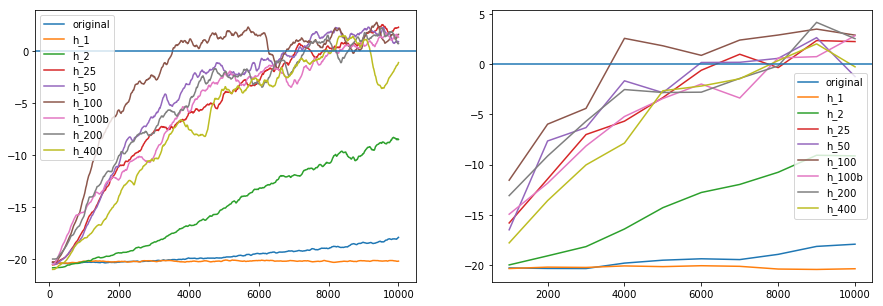

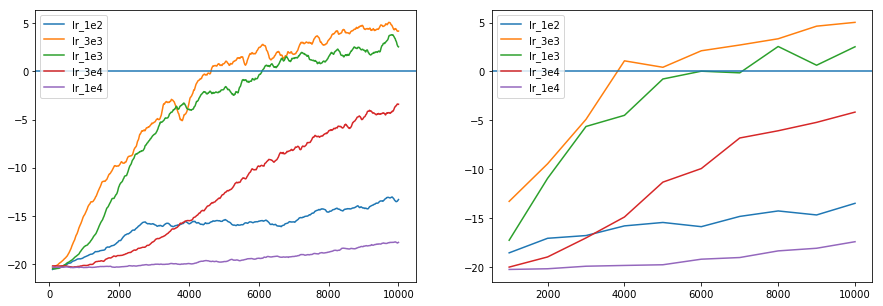

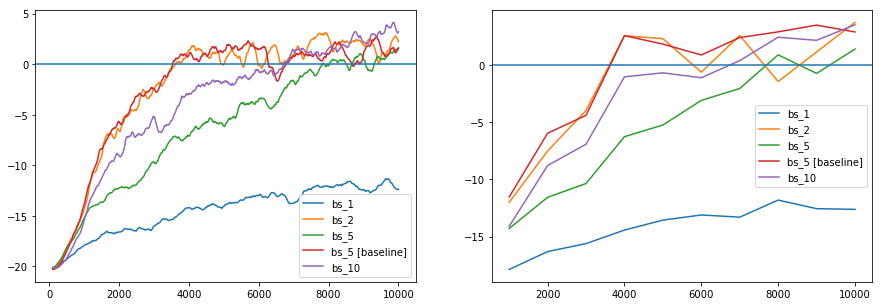

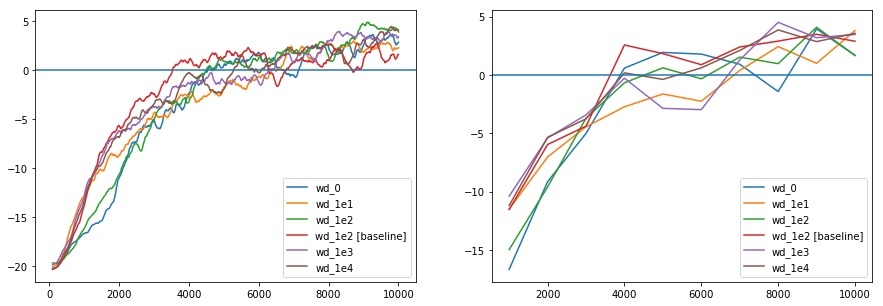

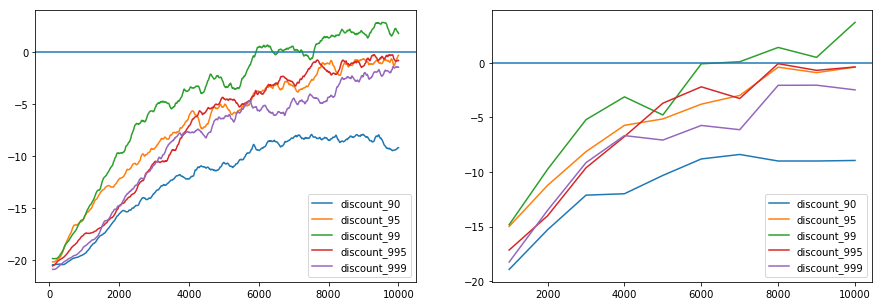

In [21]:
plt.rcParams["figure.figsize"] = (15,5)
compare_models(h_list)
compare_models(lr_list)
compare_models(bs_list)
compare_models(wd_list)
compare_models(dr_list)
#compare_models(gamma_list)

In [13]:
show_info(h_list, header = True)
show_info(lr_list)
show_info(bs_list)
show_info(wd_list)
show_info(dr_list)
show_info(gamma_list)

Name                H      LR        WD        BS        IT         TIME     (ETA)      MACHINE
original          200      0.0001    0.0       10     10000       10.2 hrs   [ 0.0]     Matthews-MacBook-Pro.local
h_1                 1      0.003     0.01       5     10000        5.6 hrs   [ 0.0]     Dell
h_2                 2      0.003     0.01       5     10000       10.7 hrs   [ 0.0]     maitchison
h_25               25      0.003     0.01       5     10000       20.7 hrs   [ 0.0]     maitchison
h_50               50      0.003     0.01       5     10000       21.1 hrs   [ 0.0]     maitchison
h_100             100      0.003     0.01       5     10000       19.5 hrs   [ 0.0]     VB-PC
h_100b            100      0.003     0.01       5     10000       19.7 hrs   [ 0.0]     maitchison
h_200             200      0.003     0.01       5     10000       28.6 hrs   [ 0.0]     maitchison
h_400             400      0.003     0.01       5     10000       17.1 hrs   [ 0.0]     n/a
lr_1e2         

std_1             100      0.003     0.01       5     10000       17.7 hrs   [ 0.0]     maitchison
std_2             100      0.003     0.01       5     10000       22.5 hrs   [ 0.0]     maitchison
std_3             100      0.003     0.01       5     10000       20.5 hrs   [ 0.0]     maitchison
std_4             100      0.003     0.01       5     10000       21.0 hrs   [ 0.0]     maitchison
std_5             100      0.003     0.01       5     10000       21.8 hrs   [ 0.0]     maitchison
h_100             100      0.003     0.01       5     10000       19.5 hrs   [ 0.0]     VB-PC


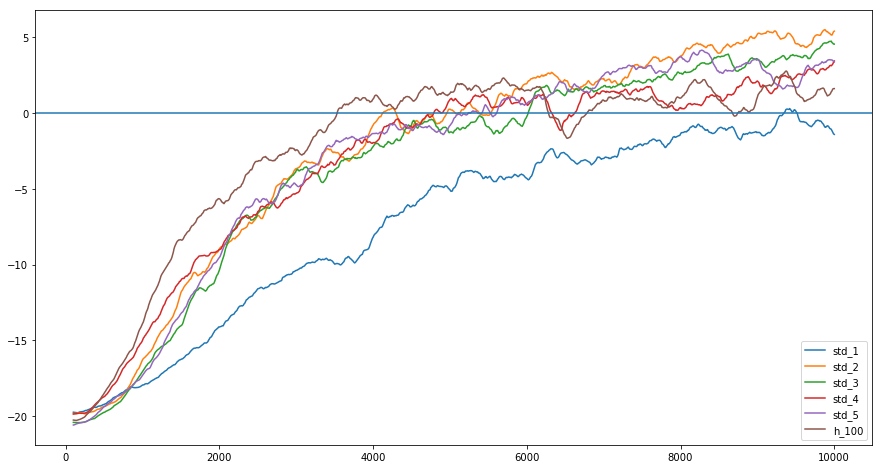

In [12]:
plt.rcParams["figure.figsize"] = (15,8)
#inspect = gamma_list
inspect = ['std_1','std_2','std_3','std_4','std_5','h_100']
#inspect = ['equiv_1','equiv_2','equiv_3','equiv_4','equiv_5', 'h_100']
show_info(inspect)
compare_models(inspect, both = False)


# std 1 shows that we should take results with a gain of started, as initialization and training can make quite a difference.
# median of 3 might be a good idea
# equiv weights are much more stable... so this would be a good idea when compairing models (atleast when H is not involved)



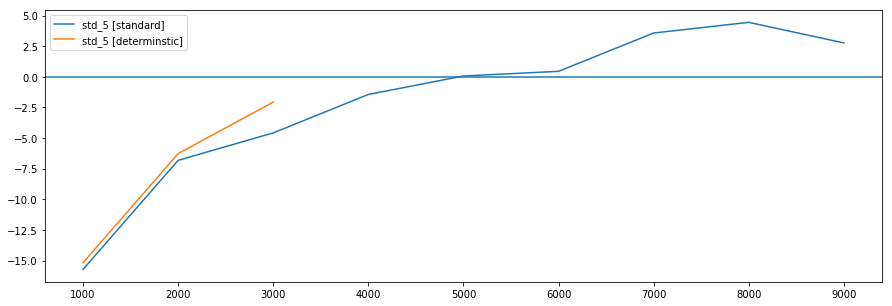

In [31]:

def compare_det_scores(name):
    """ Look at differences between deterministic and standard evaluation. """
        
    # scores
    save_package = pickle.load(open('models/'+name+".p", 'rb')) 
    
    score_history = save_package['stats']['history']
    
    max_epoch = save_package['episodes'] // 1000
    
    x,y,y_min,y_max = [], [], [], []  
    for epoch in range(1, max_epoch):
        key = epoch*1000
        if key in score_history:
            x.append(epoch*1000)
            mean = score_history[key]['score_mean']
            error = score_history[key]['score_error']
            y.append(mean)
            y_min.append(mean - error * 1.96)
            y_max.append(mean + error * 1.96)
            
    plt.plot(x, y, label = name+" [standard]")
    
    x,y = [], []
    for epoch in range(1, max_epoch):
        key = 'deterministic-'+str(epoch*1000)
        if key in score_history:
            x.append(epoch*1000)
            y.append(score_history[key]['score_mean'])
    plt.plot(x, y, label = name+" [determinstic]")

    plt.axhline(0.0)
    
    plt.legend()
    plt.show()

compare_det_scores('std_5')
    

In [9]:
# make a video
#agent = rl.Agent('h_100_10k')
#agent.train(render = True)
#p = rl.Agent('h_100')
#rint(p.config.discount_rate)

# redo gamma 99, 95, and add 97

In [10]:
[ ] Create script to re run evaluations (deterministically and non determinstically)  Also try 'don't move threshold', 
as I think the algorithm uses p=0.5 to 'stand still'

[ ] revision 2... use explore / exploit tradeoff (change over time)  Beta (alpha = beta = conf) should work.  
confidence = 1 is uniform, confidence = 100 is close to deterministic

tomorrow moring
[*] rename 'revision' to 'h'

train on on vpc
[*] train lr_3e3
[*] train bs_5
[*] train wd_1e3

[*] make 0k saves (for ref)
[ ] check if random weight init is diff on dif computers??
[*] show apply time (per episode), and check if multiple CPU helps with this?
[ ] some measure of variance on graphs... maybe 95% CI
[ ] track game length (this should be ema and stored in eval)


[ ] make a nice dashboard... maybe a nice web based one?
[ ] include 'cooking' time.  Would be nice to know how long these take to get to their trained state. 
[ ] create an evaluation script that shows distribution of steps and scores etc.
[ ] graph deterministic / normal evalulation
[ ] weights over time gif
[ ] script to setup net from command line, and another to just train a net by name (load config from file)


conclusion
3e3 to get up to 0, then 1e3 to fine tune (maybe reduce a little more over time too, say halving every 4k or so)
gamma lets us get more constant results... this is important.

wd.  less is more, probably 1e-3.  Wd 0 is bad at the start, but might work better in the futre.
Should try 1e-5, also should try 

was h100 accidently trained with gamma = .95? (it would have been using sidcount rate??)

start hparam test with same weights

SyntaxError: invalid syntax (<ipython-input-10-6fcad15fda41>, line 1)